In [2]:
import numpy as np
import pickle

class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    def forward(self, inputs):
        raise NotImplementedError

    def backward(self, grad):
        raise NotImplementedError

    def update(self, learning_rate):
        pass
    
    def save_weights(self, filepath):
        with open(filepath, 'wb') as f:
            pickle.dump(self.__dict__, f)

    def load_weights(self, filepath):
        with open(filepath, 'rb') as f:
            loaded_data = pickle.load(f)
            self.__dict__.update(loaded_data)
class LinearLayer(Layer):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.weights = np.random.randn(output_size, input_size)
        self.bias = np.random.randn(output_size)

    def forward(self, inputs):
        self.input = inputs
        self.output = np.dot(inputs, self.weights.T) + self.bias
        return self.output

    def backward(self, grad):
        grad_w = np.dot(grad.T, self.input)
        grad_b = np.sum(grad, axis=0)
        grad_input = np.dot(grad, self.weights)

        self.grad_input = grad_input  # Storing the grad_input for further computation
        self.grad_weights = grad_w
        self.grad_bias = grad_b

        return grad_input


In [3]:
#sigmoid func

class Sigmoid(Layer):
    def __init__(self):
        super().__init__()

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, inputs):
        self.input = np.clip(inputs, -500, 500)  # Clip values in the range [-500, 500]
        self.output = self._sigmoid(self.input)
        return self.output

    def backward(self, grad):
        sigmoid_grad = self.output * (1 - self.output)
        return grad * sigmoid_grad


In [4]:
#hyperbolic tangent func
class Tanh(Layer):
    def __init__(self):
        super().__init__()

    def _tanh(self, x):
        return np.tanh(x)

    def forward(self, inputs):
        self.input = inputs
        self.output = self._tanh(inputs)
        return self.output

    def backward(self, grad):
        return grad * (1 - np.power(self.output, 2))

In [5]:
#softmax func

class Softmax(Layer):
    def __init__(self):
        super().__init__()

    def _softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def forward(self, inputs):
        self.input = inputs
        self.output = self._softmax(inputs)
        return self.output

    def backward(self, grad):
        return grad

In [6]:
#cross entropy loss

class CrossEntropyLoss(Layer):
    def __init__(self):
        super().__init__()
    
    def _clip_values(self, x, epsilon):
        x = np.clip(x, epsilon, 1 - epsilon)
        return x

    def forward(self, y_pred, y_true):
        epsilon = 1e-7
        y_pred = self._clip_values(y_pred, epsilon)
        self.input = y_pred
        self.output = self._cross_entropy(y_pred, y_true)
        return self.output
    
    def backward(self, y_pred, y_true):
        epsilon = 1e-7
        m = y_true.shape[0]
        grad_input = - (y_true / (y_pred + epsilon) - (1 - y_true) / (1 - y_pred + epsilon)) / m
        return grad_input


    def _cross_entropy(self, y_pred, y_true):
        epsilon = 1e-7
        y_pred = self._clip_values(y_pred, epsilon)
        m = y_true.shape[0]
        return -np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)) / m

In [7]:
#sequential 

class Sequential(Layer):
    def __init__(self):
        super().__init__()
        self.layers = []

    def add(self, layer):
        self.layers.append(layer)

    def forward(self, inputs):
        for layer in self.layers:
            inputs = layer.forward(inputs)
        self.output = inputs
        return self.output

    def backward(self, grad):
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
        return grad


In [8]:
#XOR problem

import numpy as np
import pickle

# XOR dataset
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([[0], [1], [1], [0]])

# Using Sigmoid activation
np.random.seed(0)

# Sigmoid model
model_sigmoid = Sequential()
model_sigmoid.add(LinearLayer(2, 2))
model_sigmoid.add(Sigmoid())
model_sigmoid.add(LinearLayer(2, 1))
model_sigmoid.add(Sigmoid())

loss_function = CrossEntropyLoss()

# Training the Sigmoid model
for epoch in range(5000):
    output = model_sigmoid.forward(X)
    loss = loss_function.forward(output, y)
    grad = loss_function.backward(output, y)
    model_sigmoid.backward(grad)
    model_sigmoid.update(0.1)

model_sigmoid.save_weights('XOR_solved_sigmoid.w')

# Using Tanh activation
np.random.seed(0)

# Tanh model
model_tanh = Sequential()
model_tanh.add(LinearLayer(2, 2))
model_tanh.add(Tanh())
model_tanh.add(LinearLayer(2, 1))
model_tanh.add(Tanh())

# Training the Tanh model
for epoch in range(5000):
    output = model_tanh.forward(X)
    loss = loss_function.forward(output, y)
    grad = loss_function.backward(output, y)
    model_tanh.backward(grad)
    model_tanh.update(0.1)


model_tanh.save_weights('XOR_solved_tanh.w')

In [17]:
import kaggle

# Authenticating with the Kaggle API
kaggle.api.authenticate()

# Downloading the competition dataset
kaggle.api.competition_download_files('nyc-taxi-trip-duration', path='C:/Users/LENOVO/Downloads', force=True) 


In [ ]:
import pandas as pd
import zipfile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# extracting the dataset from zip file and then loading the dataset
zip_file_path = 'C:/Users/LENOVO/Downloads/nyc-taxi-trip-duration.zip'
destination_folder = 'C:/Users/LENOVO/Downloads'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

zip_file_path = 'C:/Users/LENOVO/Downloads/train.zip'
destination_folder = 'C:/Users/LENOVO/Downloads'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

zip_file_path = 'C:/Users/LENOVO/Downloads/test.zip'
destination_folder = 'C:/Users/LENOVO/Downloads'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)
zip_file_path = 'C:/Users/LENOVO/Downloads/sample_submission.zip'
destination_folder = 'C:/Users/LENOVO/Downloads'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

    
    
# Load the dataset into a pandas DataFrame
df = pd.read_csv('C:/Users/LENOVO/Downloads/train.csv')


Epoch 1, Train Loss: 14067.873796976419, Val Loss: 15391.255400855905
Epoch 2, Train Loss: 14067.873796976419, Val Loss: 15391.255400855905
Epoch 3, Train Loss: 14067.873796976419, Val Loss: 15391.255400855905
Early stopping: No improvement in validation loss.


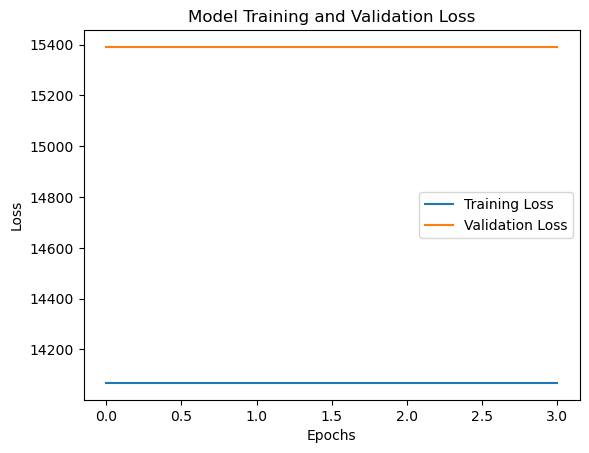

Test Loss: 15443.402795854836
Epoch 1, Train Loss: 3216.009565560012, Val Loss: 7116.372911599837
Epoch 2, Train Loss: 3216.009565560012, Val Loss: 7116.372911599837
Epoch 3, Train Loss: 3216.009565560012, Val Loss: 7116.372911599837
Early stopping: No improvement in validation loss.


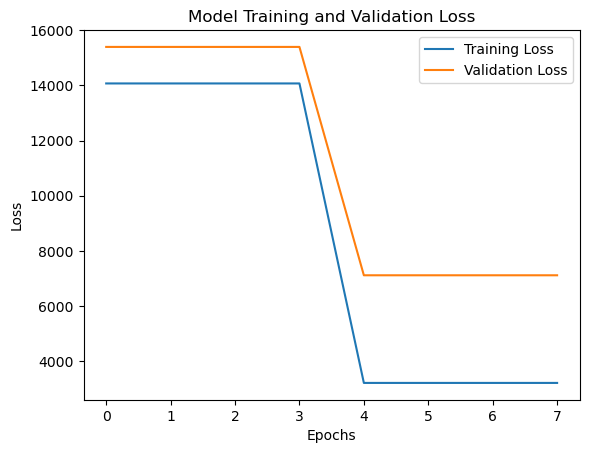

Test Loss: 7030.350173982321
Epoch 1, Train Loss: -7757.197332938693, Val Loss: -11404.820692573592
Epoch 2, Train Loss: -7757.197332938693, Val Loss: -11404.820692573592
Epoch 3, Train Loss: -7757.197332938693, Val Loss: -11404.820692573592
Early stopping: No improvement in validation loss.


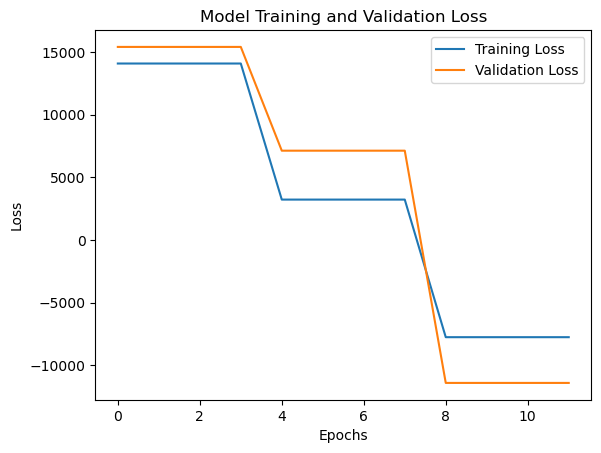

Test Loss: -11416.326707732936


In [9]:
import pandas as pd
import zipfile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Handling missing values
df = pd.read_csv('train.csv')

df = df.dropna()

# Selecting relevant features
selected_features = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'trip_duration']
df = df[selected_features]

# Split the dataset into training, validation, and testing sets
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.05, random_state=42)

# Normalize the data
scaler = StandardScaler()
train_data[selected_features[:-1]] = scaler.fit_transform(train_data[selected_features[:-1]])
val_data[selected_features[:-1]] = scaler.transform(val_data[selected_features[:-1]])
test_data[selected_features[:-1]] = scaler.transform(test_data[selected_features[:-1]])

X_train = train_data.drop(columns=['trip_duration']).values
y_train = train_data['trip_duration'].values

models = []
# Model 1
model1 = Sequential()
model1.add(LinearLayer(input_size=4, output_size=64))
model1.add(Sigmoid())
model1.add(LinearLayer(input_size=64, output_size=32))
model1.add(Sigmoid())
model1.add(LinearLayer(input_size=32, output_size=1))
models.append(model1)

# Model 2
model2 = Sequential()
model2.add(LinearLayer(input_size=4, output_size=128))
model2.add(Tanh())
model2.add(LinearLayer(input_size=128, output_size=64))
model2.add(Tanh())
model2.add(LinearLayer(input_size=64, output_size=1))
models.append(model2)

# Model 3
model3 = Sequential()
model3.add(LinearLayer(input_size=4, output_size=32))
model3.add(Tanh())
model3.add(LinearLayer(input_size=32, output_size=16))
model3.add(Tanh())
model3.add(LinearLayer(input_size=16, output_size=1))
models.append(model3)

train_losses = []
val_losses = []

for model in models:
    best_val_loss = float('inf')
    no_improvement_count = 0
    max_no_improvement = 3  # Early stopping


    batch_size = 64
    epochs = 50
    learning_rate = 1
    for epoch in range(epochs):
        for i in range(0, len(train_data), batch_size):
            batch_train_data = train_data[i:i + batch_size]
            X_batch = batch_train_data[selected_features[:-1]].values
            y_batch = batch_train_data['trip_duration'].values.reshape(-1, 1)

            # Forward pass
            outputs = model.forward(X_batch)
            train_loss = CrossEntropyLoss().forward(outputs, y_batch)

            # Backward pass
            grad = CrossEntropyLoss().backward(outputs, y_batch)
            model.backward(grad)

            # Update weights
            for layer in model.layers:
                if hasattr(layer, 'update'):
                    layer.update(learning_rate)

        # Calculate validation loss
        val_outputs = model.forward(val_data[selected_features[:-1]].values)
        val_loss = CrossEntropyLoss().forward(val_outputs, val_data['trip_duration'].values.reshape(-1, 1))

        # Append losses
        train_losses.append(train_loss)
        val_losses.append(val_loss)



        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        if no_improvement_count >= max_no_improvement:
            print("Early stopping: No improvement in validation loss.")
            break
        print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}")

    # Plot the training and validation loss
    plt.figure()
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
    plt.legend()
    plt.title("Model Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()
    
    #evaluating test loss
    test_loss = CrossEntropyLoss().forward(model.forward(test_data[selected_features[:-1]].values),
                                           test_data['trip_duration'].values.reshape(-1, 1))
    print(f"Test Loss: {test_loss}")
   